# Transmon coupled to a resonator

This example is fundamentally different to the other circuits discussed in this documentation in two ways. First, it does not describe a single system or qubit, but the coupling of a qubit (here: transmon) with another system (here: resonator). With its current implementation design, CircuitQ treads the entire circuit as a single system and provides the description of the whole system with one Hamiltonian. Second, the numerical implementation of this circuit will be provided by a mixture of the charge and flux basis, as the copuling capacity seperates the resonator as a harmonic system implemented in the flux basis from the transmon, which is implemented in the charge basis.

In [1]:
import circuitq as cq
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#### Circuit Graph

We initialize a transmon coupled to a resonator (LC circuit) via a capacity.

<img src="circuit_figures/transmon_c_resonator_circuit.png" alt="Transmon coupled to resonator" width="250"/>


In [2]:
graph = nx.MultiGraph()
graph.add_edge(0,1, element = 'C')
graph.add_edge(0,1, element = 'J')
graph.add_edge(1,2, element = 'C')
graph.add_edge(3,2, element = 'C')
graph.add_edge(3,2, element = 'L');

#### Symbolic Hamiltonian

We will set node 0 and 3 to the ground.

In [3]:
circuit = cq.CircuitQ(graph, ground_nodes=[0,3])

In [4]:
circuit.h

-E_{J010}*cos(\Phi_{1}/\Phi_{o}) + 0.5*q_{1}*(C_{12}*q_{2}/(C_{01}*C_{12} + C_{01}*C_{23} + C_{12}*C_{23}) + q_{1}*(C_{12} + C_{23})/(C_{01}*C_{12} + C_{01}*C_{23} + C_{12}*C_{23})) + 0.5*q_{2}*(C_{12}*q_{1}/(C_{01}*C_{12} + C_{01}*C_{23} + C_{12}*C_{23}) + q_{2}*(C_{01} + C_{12})/(C_{01}*C_{12} + C_{01}*C_{23} + C_{12}*C_{23})) + \Phi_{2}**2/(2*L_{230})

(horizontally scroll the above LaTeX output)

The Hamiltonian contains a periodic cosine potential caused by the transmon an the harmonic part of the resonator. The nodes associated with the transmon will be implemented in the charge basis, which is also reflected in the value of `charge_basis_nodes`:

In [5]:
circuit.charge_basis_nodes

[0, 1]

To prevent the usage of the charge basis, you can specify the list of nodes for which a flux basis implementation should be forced with the keyword `force_flux_nodes` when initialising a `CircuitQ` instance.

#### Diagonalization

The calculation of eigenstates and eigenvalues of the Hamiltonian is done in the mixed basis. To be able to plot the eigenstates in the flux basis, we use the method `transform_charge_to_flux()` and subsequently address the eigensates stored in `estates_in_phi_basis`.

In [6]:
dim = 50
h_num = circuit.get_numerical_hamiltonian(50)
eigv, eigs = circuit.get_eigensystem()
circuit.transform_charge_to_flux()
eigs = circuit.estates_in_phi_basis

Let's plot the potential, which is an overlay of the cosine potential in one direction and a parabola in the other direction.

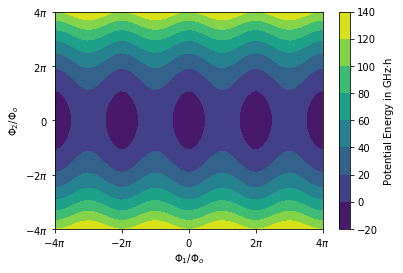

In [7]:
def potential(phi_1, phi_2):
    return (-circuit.c_v['E']*np.cos(phi_1/circuit.phi_0) + phi_2**2/(2*circuit.c_v['L']))
phis = np.linspace(-4*np.pi*circuit.phi_0, 4*np.pi*circuit.phi_0, dim)
h = 6.62607015e-34 
y_scaling = 1/(h *1e9)
potential_list = [potential(phi_1,phi_2)*y_scaling for phi_2 in phis for phi_1 in phis]
plt.contourf(phis, phis, np.array(potential_list).reshape(dim,dim))
plt.xticks(np.linspace(-4*np.pi, 4*np.pi, 5)*circuit.phi_0 ,
           [r'$-4\pi$',r'$-2\pi$',r'$0$',r'$2\pi$',r'$4\pi$'])
plt.yticks(np.linspace(-4*np.pi, 4*np.pi, 5)*circuit.phi_0 ,
           [r'$-4\pi$',r'$-2\pi$',r'$0$',r'$2\pi$',r'$4\pi$'])
plt.xlabel(r"$\Phi_1 / \Phi_o$")
plt.ylabel(r"$\Phi_2 / \Phi_o$")
plt.colorbar(label="Potential Energy in GHz$\cdot$h")
plt.show()

Finally, we plot the lowest eigenstates depicted in the flux basis. 

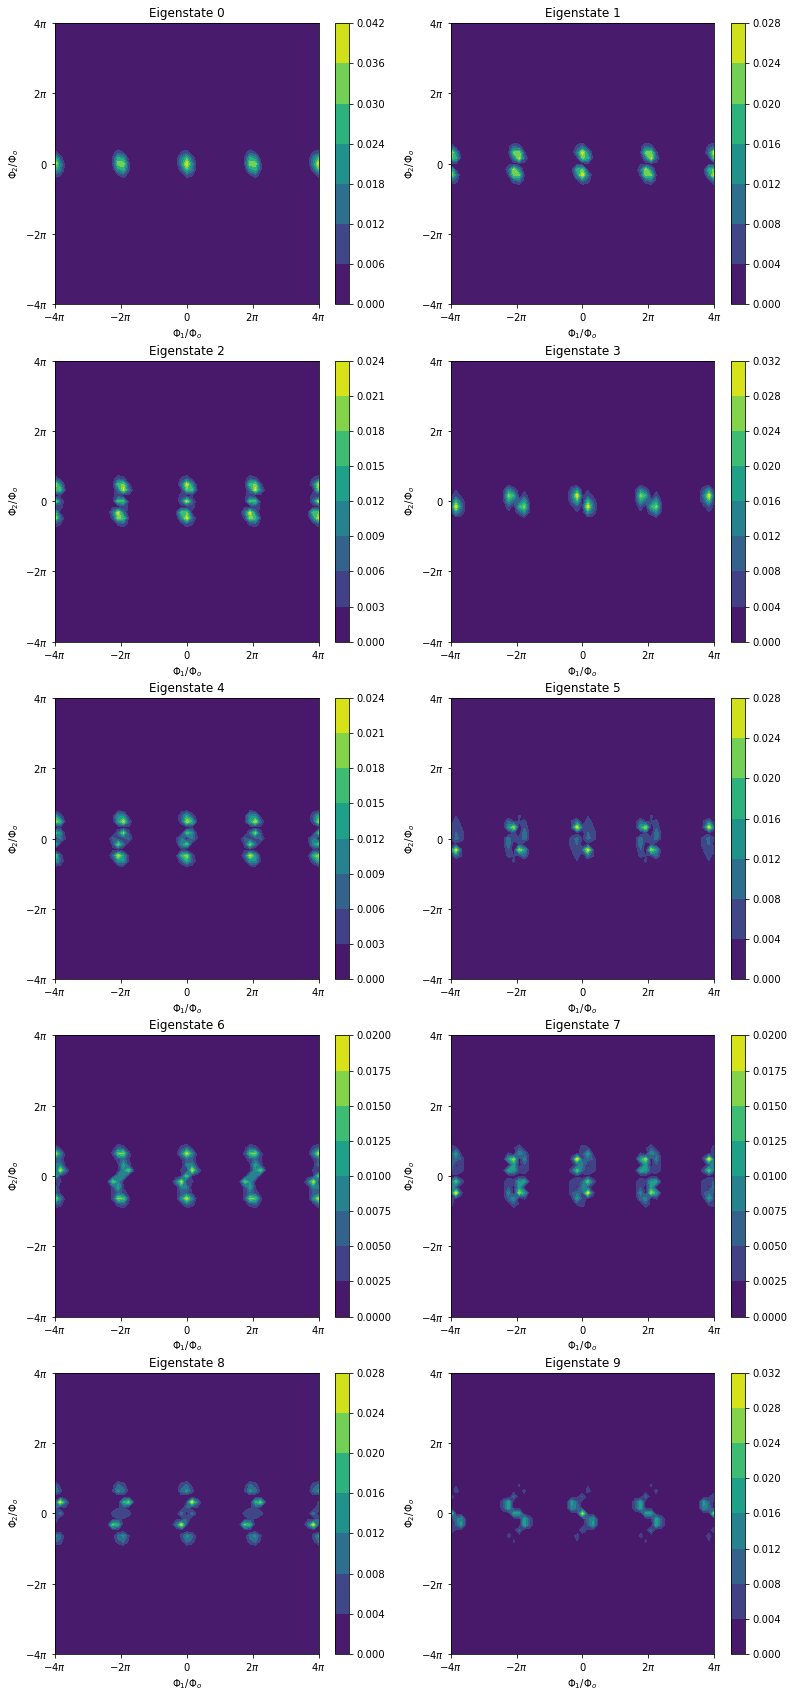

In [8]:
plt.figure(figsize=(13,30))
for n in range(10):
    plt.subplot(5,2, n+1)
    plt.contourf(circuit.flux_list, circuit.flux_list, 
        abs(np.array(eigs[n].reshape(circuit.n_dim,circuit.n_dim)).transpose())**2)
    plt.colorbar()
    plt.title("Eigenstate " + str(n) )
    plt.xticks(np.linspace(-4*np.pi, 4*np.pi, 5)*circuit.phi_0 ,
               [r'$-4\pi$',r'$-2\pi$',r'$0$',r'$2\pi$',r'$4\pi$'])
    plt.yticks(np.linspace(-4*np.pi, 4*np.pi, 5)*circuit.phi_0 ,
               [r'$-4\pi$',r'$-2\pi$',r'$0$',r'$2\pi$',r'$4\pi$'])
    plt.xlabel(r"$\Phi_1 / \Phi_o$")
    plt.ylabel(r"$\Phi_2 / \Phi_o$")
plt.show()